Поділимо дані нашого датасету на 3 кластери ієрархічним методом, як в попередньому ДЗ.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
df = pd.read_csv('airbnb_london_clean.csv')
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,121.122322,Private room,False,True,2.0,False,0,0,6.0,69.0,1,5.734117,0.437094,222.882243,15.493414,470.088502,8.413765,-0.04975,51.52570
1,195.912416,Private room,False,True,2.0,False,1,0,10.0,96.0,1,4.788905,1.464050,235.385841,16.362588,530.133525,9.488466,-0.08475,51.54210
2,193.325337,Private room,False,True,3.0,False,1,0,10.0,95.0,1,4.596677,0.450306,268.913812,18.693247,548.987610,9.825922,-0.14585,51.54802
3,180.389943,Private room,False,True,2.0,False,1,0,9.0,87.0,1,2.054769,0.132670,472.381314,32.837067,1021.271062,18.278973,-0.10611,51.52108
4,405.700981,Entire home/apt,False,False,3.0,False,0,1,7.0,65.0,0,4.491277,0.354108,318.491470,22.139584,692.775411,12.399473,-0.18797,51.49399


In [97]:
X = df.iloc[:, [14, 16]].values

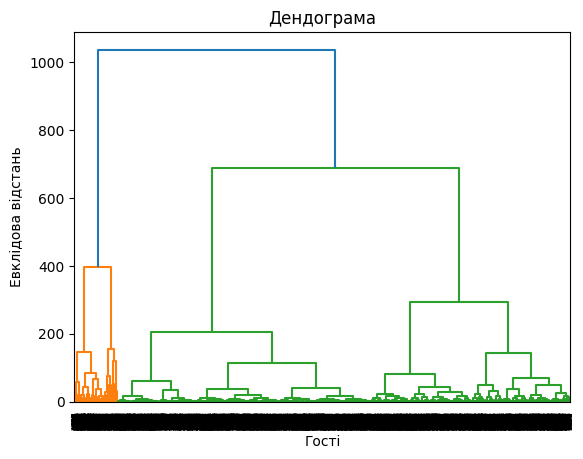

In [98]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Дендограма')
plt.xlabel('Гості')
plt.ylabel('Евклідова відстань')
plt.show()

In [99]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

In [100]:
df['Cluster'] = y_hc
cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_table = pd.DataFrame([cluster_counts], index=['Кількість елементів'])
cluster_table.columns = [f'Кластер {i+1}' for i in cluster_table.columns]
cluster_table

,Кластер 1,Кластер 2,Кластер 3
Кількість елементів,465,2166,2744


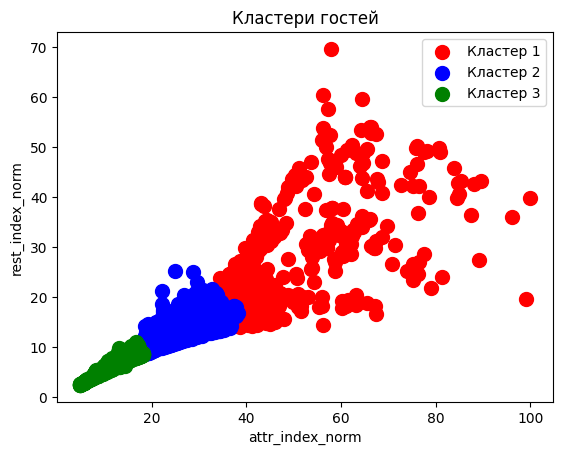

In [101]:
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Кластер 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Кластер 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Кластер 3')
plt.title('Кластери гостей')
plt.xlabel('attr_index_norm')
plt.ylabel('rest_index_norm')
plt.legend()
plt.show()

Отже, тепер знайдемо 2 найбільших кластера.

In [102]:
cluster_counts = df['Cluster'].value_counts().sort_values(ascending=False)
largest_clusters = cluster_counts.index[:2]

In [103]:
X = df[df['Cluster'].isin(largest_clusters)].copy()
Y = X['Cluster']
X = X[['attr_index_norm', 'rest_index_norm']]

Застосуємо метод опорних векторів (Support Vector Machine).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=23)
clf = SVC(kernel='rbf', random_state=23)
clf.fit(x_train, y_train)

В нашому випадку ми застосували ядро радіальної базисної функції (RBF). Саме тут таке ядро підходить ідеально, оскільки RBF ядро може моделювати складні розподіли для нелінійних даних (в нашому випадку змінні attr_index_norm та rest_index_norm не залежать одна від одної). Далі зможемо побачити на графіку, що гіперплощина, яка "ділить" кластери, є криволінійною саме завдяки RBF ядру.

Визначимо точність класифікації:

In [109]:
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Точність класифікації = {accuracy} = {str(accuracy*100)[:6]}%')

Точність класифікації = 0.9938900203665988 = 99.389%


Візуалізуємо розподіл.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


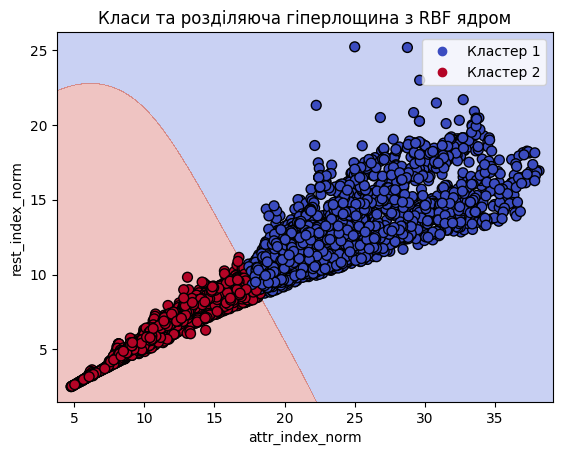

In [110]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = X['attr_index_norm'].min() - 1, X['attr_index_norm'].max() + 1
y_min, y_max = X['rest_index_norm'].min() - 1, X['rest_index_norm'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
scatter = plt.scatter(X['attr_index_norm'], X['rest_index_norm'], c=Y, cmap=plt.cm.coolwarm, edgecolor='k', s=50)
plt.legend(handles=scatter.legend_elements()[0], labels=['Кластер 1', 'Кластер 2'])
plt.xlabel('attr_index_norm')
plt.ylabel('rest_index_norm')
plt.title('Класи та розділяюча гіперлощина з RBF ядром')

plt.show()

Отже, ми бачимо, що наша модель дійсно дуже добре впоралась із своєю задачею класифікації двох кластерів за допомогою методу опорних векторів. Побудована межа дійсно з надзвичайно великою точністю розподіляє елементи двох різних кластерів.